In [10]:
import eagleSqlTools as est
import numpy as np
import matplotlib.colors
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation
import matplotlib.pyplot as plt
import healpy as hp
from mpl_toolkits import mplot3d

In [11]:
conn = est.connect("lzm898", "YB854nic", "http://virgodb.dur.ac.uk:8080/MyMillennium")

In [12]:
##Let us do another constraint, mstars_bulge+mstars_disk>=10^7

In [13]:
query3="SELECT gal.x, gal.y, gal.z, halo.m200_crit FROM McAlpine2022a..galaxy as gal, McAlpine2022a..halo as halo WHERE mstars_disk+mstars_bulge >1e7 AND gal.hosthaloid=halo.hosthaloid AND gal.rank=0"

In [14]:
#check
query="SELECT gal.x, gal.y, gal.z, halo.m200_crit, dist FROM McAlpine2022a..galaxy as gal, McAlpine2022a..halo as halo WHERE mstars_disk+mstars_bulge >1e11 AND gal.hosthaloid=halo.hosthaloid AND gal.rank=0 and galaxyid=5098129"

In [15]:
res3=est.execute_query(conn, query3)

In [16]:
print(res3)

[( 130.8505  , 117.45914 ,  -42.342285, 1.61041988e+08)
 (  34.89151 , 142.30692 , -107.27298 , 1.84047986e+08)
 (  44.2269  , 180.59927 ,  -35.861603, 1.84047986e+08) ...
 ( -24.39325 , 120.00241 ,  138.38605 , 8.78829132e+09)
 (-104.721436,  18.762787,   53.100952, 8.78829132e+09)
 (  -9.293457, 153.30551 ,    8.368713, 8.78829132e+09)]


In [17]:
np.save('res3.npy', res3)

In [18]:
xyzm3 = np.load('res3.npy')

In [19]:
xyzm3=sorted(xyzm3, key=lambda x:np.sqrt(x[0]**2+x[1]**2+x[2]**2))

In [20]:
s3=len(xyzm3)

In [21]:
N=len(xyzm3)
dist=np.zeros(N)
dist_vec=np.zeros((s3,3))
m_halo=np.zeros(s3)
for i in range(N):
    dist[i]=np.sqrt(xyzm3[i][0]**2+xyzm3[i][1]**2+xyzm3[i][2]**2)#Finding distances of different dark matter halos from Milkey way
    dist_vec[i]=np.array([xyzm3[i][0], xyzm3[i][1], xyzm3[i][2]])
    m_halo[i]=xyzm3[i][3]

In [22]:
m=16
j=np.zeros(m, dtype=int)
steps=[1, 10, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
steps1=[10, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
for i in range(s3):
    if dist[i]>=steps[0]:
        start=i
        break
print(dist[i])
for k in range(1,m+1):
    while dist[i]  < steps[k]:
        j[k-1]+=1 # in j array we keep the number of galaxies corresponding to the relevan shell
        i+=1
        if i > s3-1:
            break
            #if k==9:
               #print(9)

1.020220803781713


In [23]:
print(j)

[   378  53947  36709  54964  58047  71853  91349 112687 139253 168335
 175494 197010 231107 251436 262758 296593]


In [24]:
G=6.67*10**(-11)

In [25]:
ac_vec=[[]]*m
ac_scal=[[]]*m
for i in range(m):
    ac_vec[i]=np.zeros((j[i],3))
    ac_scal[i]=np.zeros(j[i])

In [26]:
print(len(ac_vec[1]))

53947


In [27]:
scale=1.99*10**30/(3.08*10**22)**2

In [28]:
i=start
for k in range(1,m+1):
    p=0
    while dist[i]  <= steps[k]:
        ac_vec[k-1][p]=(G*m_halo[i]*scale/dist[i]**3)*dist_vec[i] #in m/s^2
        i+=1
        p+=1
        ac_scal[k-1][p-1]=np.linalg.norm(ac_vec[k-1][p-1])
        if i>s3-1:
            break
    #print(ac_scal[k-1][p-1])

In [29]:
#calculating mean and standard veviation

In [30]:
mean_val=np.zeros(m)
st_dev=np.zeros(m)

In [31]:
#print(mean_val[i])
#print(mean_valnorm)

In [32]:
print(max(ac_vec[0][1]))

1.934281697465629e-15


In [33]:
Nside3 = 64
r=0.5
npix3 = hp.nside2npix(Nside3)
bins=hp.nside2npix(Nside3)
pix_indices=[[]]*m
counts=[[]]*m
max_idx=np.zeros(m)
for i in range(m):
    pix_indices[i]=np.zeros(j[i])
    counts[i]=np.zeros(bins)

/Users/user/.local/lib/python3.9/site-packages/healpy/pixelfunc.py:656: RuntimeWarning: divide by zero encountered in _vec2pix_ring
  return pixlib._vec2pix_ring(nside, x, y, z)
/Users/user/.local/lib/python3.9/site-packages/healpy/pixelfunc.py:656: RuntimeWarning: invalid value encountered in _vec2pix_ring
  return pixlib._vec2pix_ring(nside, x, y, z)


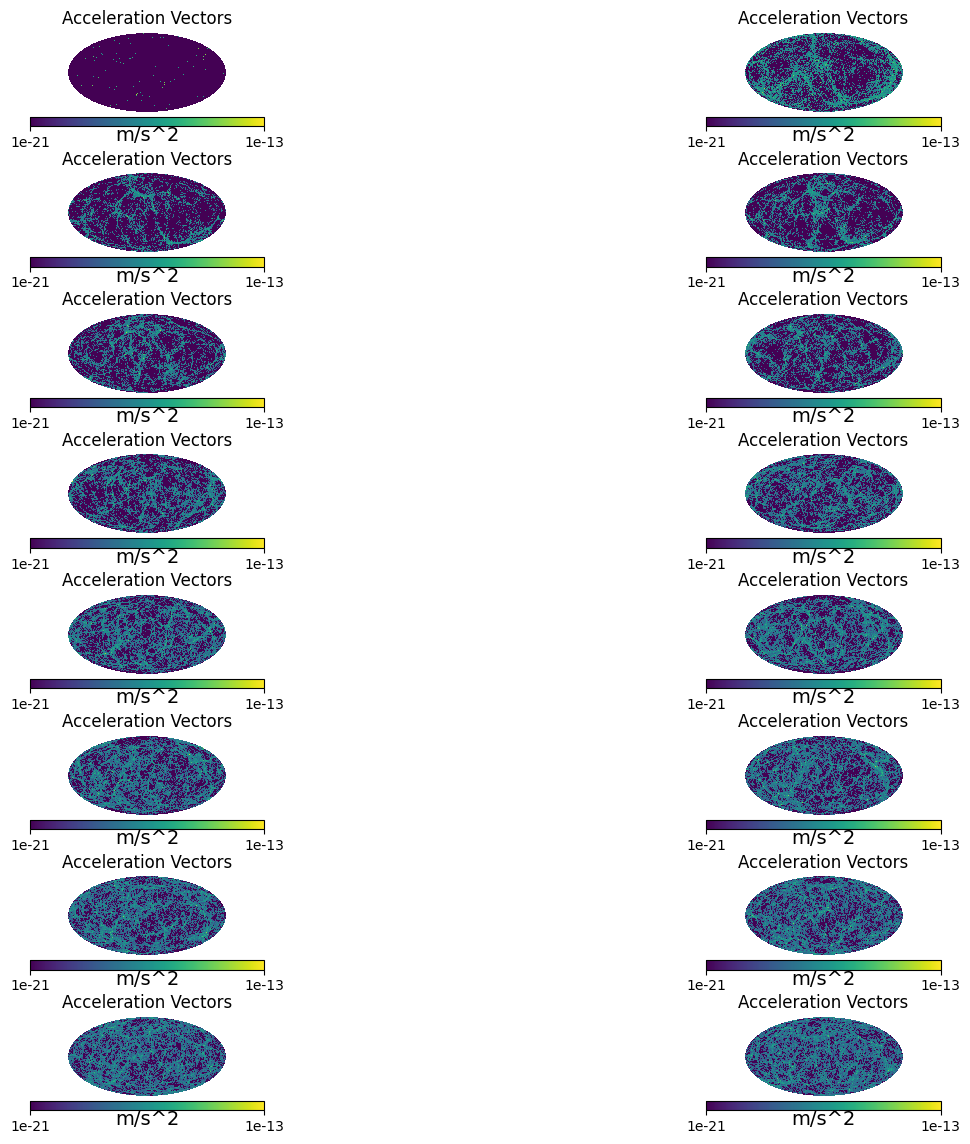

In [34]:
fig, axs = plt.subplots(ncols=2, nrows=8, gridspec_kw={'hspace': 0.5}, figsize=(16,14))
axs = axs.flatten()
for k in range(m):
    pix_indices[k]=hp.pixelfunc.vec2pix(Nside3, list(ac_vec[k][:,0]*u.dimensionless_unscaled),
        list(ac_vec[k][:,1]*u.dimensionless_unscaled),
        list(ac_vec[k][:,2]*u.dimensionless_unscaled))
    counts[k],_=np.histogram(pix_indices[k],bins, weights=ac_scal[k])
    counts[k][counts[k]<=1e-21]=1e-21
    #max_idx[k]=argmax(counts[k])
    mean_val[k]=np.sum(counts[k])/bins
    st_dev[k]=np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins)
    plt.axes(axs[k])
    hp.mollview(counts[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title='Acceleration Vectors', unit='m/s^2', badcolor="white",hold=True)
    #plt.plot(mean_valnorm[k][0]*r, mean_valnorm[k][1]*r, color='r', marker='o')
plt.show()

    #print(counts[k])
    #print(pix_indices[k])

In [35]:
#check
#mean_val[1]
np.sum((counts[1]-mean_val[1])**2)
print(np.amax(ac_vec[5]))

1.667634572777741e-15


In [36]:
# calculate pixel size:
pixel_size=4*3.14/(12*Nside3**2)
#in square degrees
print(pixel_size)

0.00025553385416666666


In [37]:
#Now let us calculate acceleration theoretically by omega matter
rho_matter= 2.2*10**(-27) #kg/m^3
steps2=np.array(steps1)
r=steps2*3.08*10**22
print(steps1)
r=np.array(r)
dr=10*3.08*10**22
m_shell=r**2*dr*pixel_size*rho_matter
acceleration=m_shell*G/(r**2)
print(m_shell*G)
print(r**2)
print(acceleration)
##we got that acceleration coinsides more or less than mean value 1-^-16

[10, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[1.0955926489520834e+30 3.9441335362275014e+31 5.368403979865209e+31
 7.011792953293334e+31 8.874300456511876e+31 1.0955926489520834e+32
 1.3256671052320211e+32 1.5776534144910005e+32 1.8515515767290213e+32
 2.1473615919460835e+32 2.4650834601421872e+32 2.8047171813173335e+32
 3.1662627554715217e+32 3.54972018260475e+32 3.955089462717022e+32
 4.382370595808334e+32]
[9.4864e+46 3.415104000000001e+48 4.6483360000000006e+48 6.071296e+48
 7.683984e+48 9.486400000000002e+48 1.1478544000000003e+49
 1.3660416000000004e+49 1.6032016000000005e+49 1.8593344000000002e+49
 2.1344399999999996e+49 2.4285184e+49 2.741569600000001e+49 3.0735936e+49
 3.424590400000001e+49 3.7945600000000007e+49]
[1.1549087630208334e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.1549087630208334e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.1549087630208334e-17 1.1549087630208334e-17 1.1549087630208332e-17
 1.1549087630208332e-17 1.

In [38]:
# check
print(mean_val[1], counts[1])
print(np.sum((counts[1]-mean_val[1])**2))

2.2007021551924533e-17 [8.81114519e-18 1.17438475e-17 1.46196873e-17 ... 1.33736786e-17
 1.03531927e-18 1.68970281e-18]
1.6753260281604386e-26


In [39]:
# check
for k in range (m):
    st_dev[k]=np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins)
    #print (np.sqrt(np.sum((counts[k]-mean_val[k])**2)/bins))
print(st_dev)  

[2.69002933e-16 5.83820138e-16 1.06610577e-16 3.65474610e-16
 6.81165353e-17 3.67079235e-17 1.12481957e-16 4.79218528e-17
 5.71506471e-17 5.40063808e-17 7.80680869e-17 6.75948824e-17
 5.09206851e-17 4.00114782e-17 4.13265866e-17 2.91161533e-17]


In [40]:
print(st_dev[1])

5.838201375379929e-16


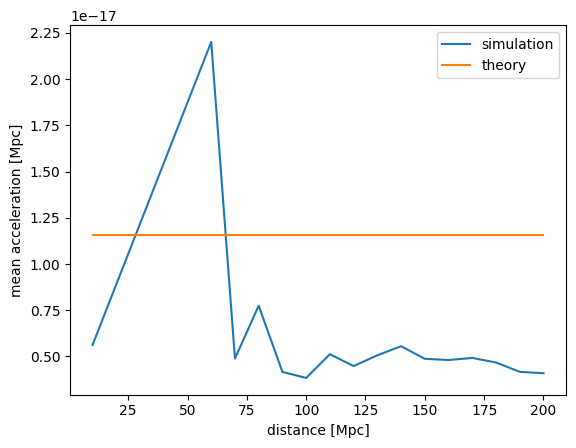

In [41]:
fig,ax=plt.subplots()
plt.plot(steps1, mean_val, label="simulation")
plt.plot(steps1, acceleration, label="theory")
plt.xlabel("distance [Mpc]")
plt.ylabel("mean acceleration [Mpc]")
plt.legend()

Text(0, 0.5, 'standard deviation')

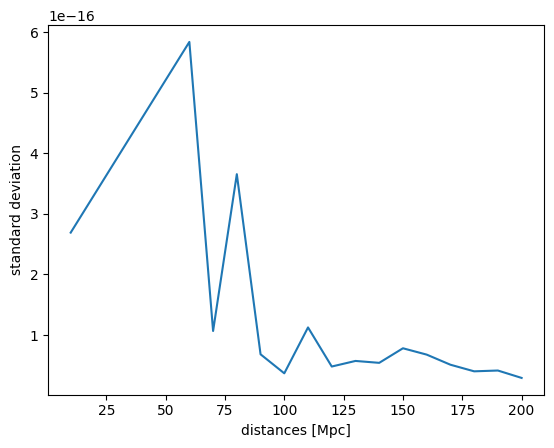

In [42]:
plt.plot(steps1, st_dev)
plt.xlabel("distances [Mpc]")
plt.ylabel("standard deviation")

In [43]:
#cumulative graphs and means

In [44]:
pix_indices2=[[]]*m
counts2=[[]]*m
max_idx2=np.zeros(m)
for i in range(m):
    pix_indices2[i]=np.zeros(j[i])
    counts2[i]=np.zeros(bins)

In [45]:
ac_vec2=[[]]*m
ac_scal2=[[]]*m
s=0
for i in range(m):
    s+=j[i]
    ac_vec2[i]=np.zeros((s,3))
    ac_scal2[i]=np.zeros(s)

In [46]:
i=start
for k in range(1,m+1):
    p=0
    i=start
    while dist[i]  < steps[k]:
        ac_vec2[k-1][p]=(G*m_halo[i]*scale/dist[i]**3)*dist_vec[i] #in m/s^2
        i+=1
        p+=1
        ac_scal2[k-1][p-1]=np.linalg.norm(ac_vec2[k-1][p-1])
        if i>s3-1:
            break

In [47]:
mean_val2=np.zeros(m)
st_dev2=np.zeros(m)

In [48]:
mean_val2=np.zeros((m,3))
mean_valnorm2=np.zeros((m,3))
mean_scal2=np.zeros(m)
for i in range(m):
    mean_val2[i]=(sum(ac_vec2[i]))/j[i]
    #print(mean_valnorm[i])

In [49]:
print(sum(ac_vec2[1]))

[-2.09689765e-13  6.06109018e-14 -2.67099358e-14]


In [50]:
x=np.zeros(m);  ra=np.zeros(m)
y=np.zeros(m);  dec=np.zeros(m)
z=np.zeros(m);  phi=np.zeros(m);  phi_pix=np.zeros(m)
norm=np.zeros(m); theta=np.zeros(m); theta_pix=np.zeros(m)
ipix=np.zeros(m, dtype=int)

In [51]:
a=np.zeros(m, dtype=np.ndarray)
print(type(a[1]))

<class 'int'>


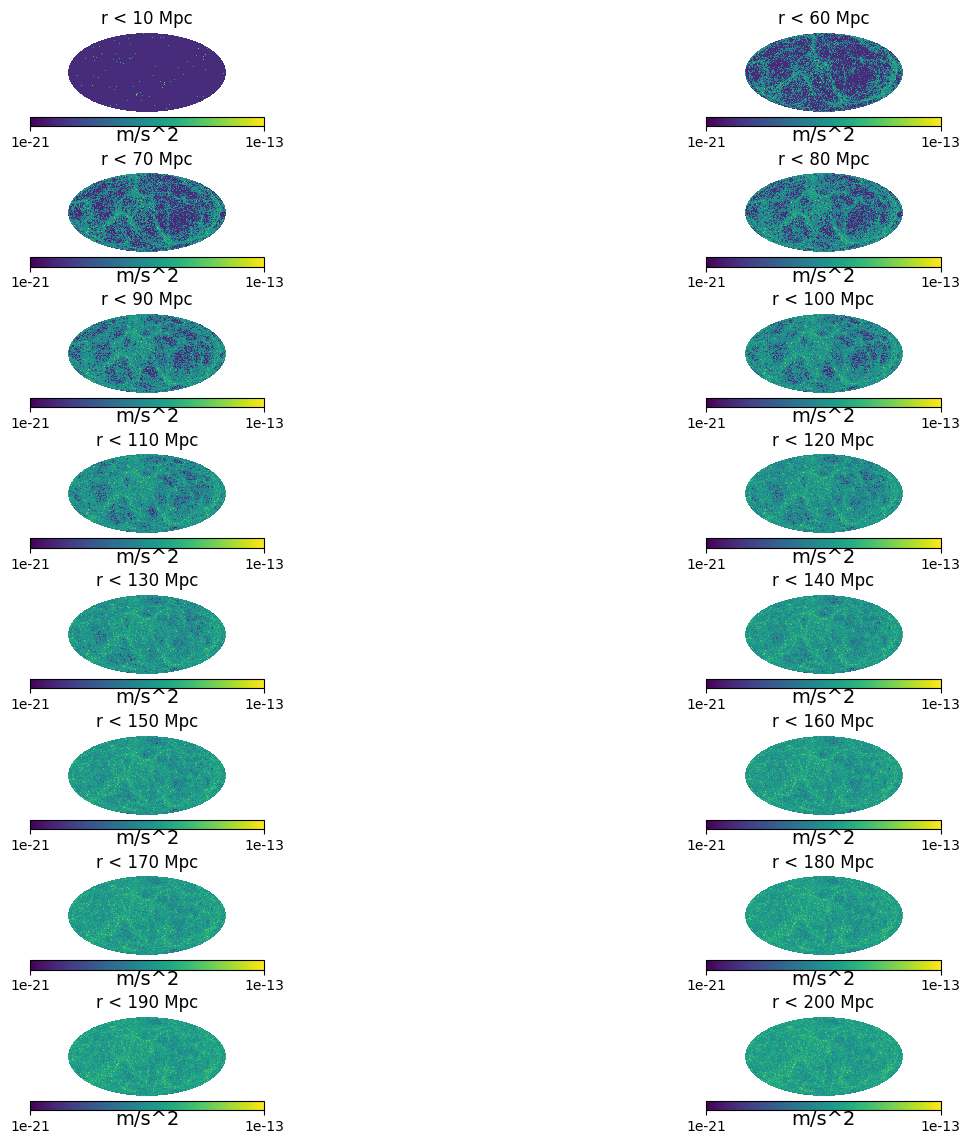

In [52]:
fig, axs = plt.subplots(ncols=2, nrows=8, gridspec_kw={'hspace': 0.5}, figsize=(16,14))
axs = axs.flatten()
for k in range(m):
    pix_indices2[k]=hp.pixelfunc.vec2pix(Nside3, list(ac_vec2[k][:,0]*u.dimensionless_unscaled),
        list(ac_vec2[k][:,1]*u.dimensionless_unscaled),
        list(ac_vec2[k][:,2]*u.dimensionless_unscaled))
    counts2[k],_=np.histogram(pix_indices2[k],bins, weights=ac_scal2[k])
    counts2[k][counts2[k]<=1e-20]=1e-20
    #max_idx[k]=argmax(counts[k])
    plt.axes(axs[k])
    ax=axs[k]
    hp.mollview(counts2[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title=("r < {} Mpc".format(steps[k+1])),unit='m/s^2', badcolor="white", sub=(1,k,k), hold=True)
    dec[k] = np.arctan(mean_val2[k][2]/(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2)))
    ra[k]=np.arctan(mean_val2[k][1]/mean_val2[k][0])
    theta[k] = np.pi/2.0 - dec[k]
    phi[k] = ra[k]
    #ipix[k] = hp.ang2pix(Nside3, theta[k], phi[k])

# Convert ipix to (theta, phi) coordinates
    #theta_pix[k], phi_pix[k] = hp.pix2ang(Nside3, ipix[k], nest=False)

    #hp.mollview(counts2[k], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13 ,unit='m/s^2', badcolor="white",hold=True)
    #hp.visufunc.projscatter(phi[k], theta[k], color='red', s=10)
    #print(k)
    
    #hp.projscatter(ipix[k], lonra=ra[k]*180.0/np.pi, latdec=dec[k]*180/np.pi, c='o', color='red', s=10)
plt.show()

In [53]:
#check
nside = 16

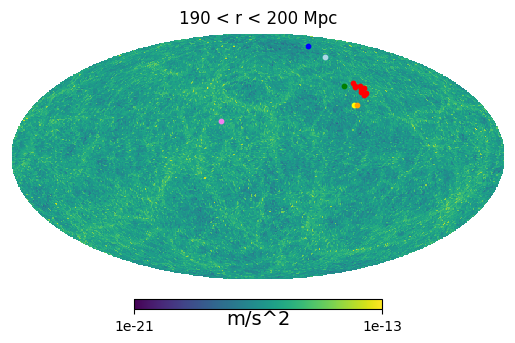

In [54]:
#mean acceleration direction

hp.mollview(counts2[15], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title=("{} < r < {} Mpc".format(steps[15],steps[k+1])),unit='m/s^2', badcolor="white",hold=True)
hp.visufunc.projscatter(phi[0], theta[0], color='violet', s=10)
hp.visufunc.projscatter(phi[1], theta[1], color='blue', s=10)
hp.visufunc.projscatter(phi[2], theta[2], color='lightblue', s=10)
hp.visufunc.projscatter(phi[3], theta[3], color='green', s=10)
hp.visufunc.projscatter(phi[4], theta[4], color='yellow', s=10)
hp.visufunc.projscatter(phi[5], theta[5], color='orange', s=10)
hp.visufunc.projscatter(phi[6], theta[6], color='red', s=10)
hp.visufunc.projscatter(phi[7], theta[7], color='red', s=10)
hp.visufunc.projscatter(phi[8], theta[8], color='red', s=10)
hp.visufunc.projscatter(phi[9], theta[9], color='red', s=10)
hp.visufunc.projscatter(phi[10], theta[10], color='red', s=10)
hp.visufunc.projscatter(phi[11], theta[11], color='red', s=10)
hp.visufunc.projscatter(phi[12], theta[12], color='red', s=10)
hp.visufunc.projscatter(phi[13], theta[13], color='red', s=10)
hp.visufunc.projscatter(phi[14], theta[14], color='red', s=10)
hp.visufunc.projscatter(phi[15], theta[15], color='red', s=10)

In [55]:
# now we will plot velocity vector and acceleration vector for r<10 Mpc because in paper velocity is in that shell given
# observation: l=271+=2 degree, b=29+- 1 deg
#SD: l=232 deg, b=7 deg
# b -dec, l - ra

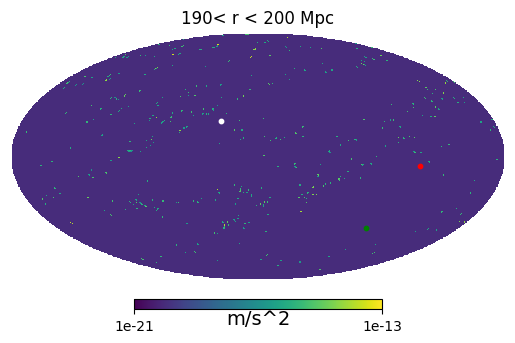

In [56]:
b_vel_obs=29*0.017
l_vel_obs=271*0.017
b_vel_sim=7*0.017
l_vel_sim=232*0.017
theta_vel_obs=np.pi/2.0-b_vel_obs
phi_vel_obs=l_vel_obs
theta_vel_sim=np.pi/2.0-b_vel_sim
phi_vel_sim=l_vel_sim
hp.mollview(counts2[0], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title=("{}< r < {} Mpc".format(steps[k],steps[k+1])),unit='m/s^2', badcolor="white",hold=True)
hp.visufunc.projscatter(phi_vel_obs, theta_vel_obs, color='red', s=10)
hp.visufunc.projscatter(phi_vel_sim, theta_vel_sim, color='green', s=10)
hp.visufunc.projscatter(phi[0], theta[0], color='white', s=10)

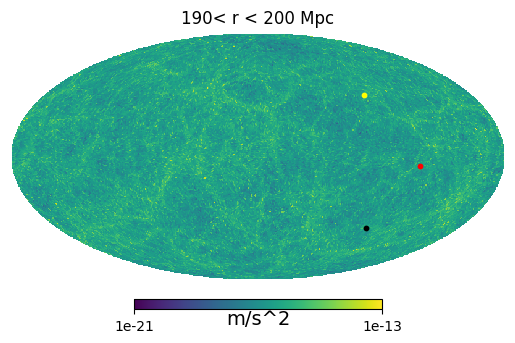

In [57]:
b_vel_obs=29*0.017
l_vel_obs=271*0.017
b_vel_sim=7*0.017
l_vel_sim=232*0.017
theta_vel_obs=np.pi/2.0-b_vel_obs
phi_vel_obs=l_vel_obs
theta_vel_sim=np.pi/2.0-b_vel_sim
phi_vel_sim=l_vel_sim
hp.mollview(counts2[15], norm=matplotlib.colors.LogNorm(), min=1e-21, max=1e-13, title=("{}< r < {} Mpc".format(steps[k],steps[k+1])),unit='m/s^2', badcolor="white",hold=True)
hp.visufunc.projscatter(phi_vel_obs, theta_vel_obs, color='red', s=10)
hp.visufunc.projscatter(phi_vel_sim, theta_vel_sim, color='black', s=10)
hp.visufunc.projscatter(phi[15], theta[15], color='yellow', s=10)

In [58]:
#check, it is interesting bit I get the same ratio for each 
for k in range(2):
    #print(mean_val2[k])
    print(mean_val2)
    print((np.arctan(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2))))
    print((mean_val2[k][2]/(np.sqrt(mean_val2[k][0]**2+mean_val2[k][1]**2))))
    

[[ 3.67256375e-17  9.69696105e-17  1.92019781e-16]
 [-3.88695878e-18  1.12352683e-18 -4.95114386e-19]
 [-4.92004469e-18  2.41633340e-18 -8.17161552e-19]
 [-1.80615158e-18  1.92405457e-18 -6.45870538e-19]
 [-1.17356527e-18  1.94983805e-18 -5.25771274e-19]
 [-1.01531728e-18  1.71157109e-18 -3.84081764e-19]
 [-1.21365204e-18  1.28918106e-18 -1.14587478e-19]
 [-1.00552672e-18  9.90152244e-19 -9.08723189e-20]
 [-8.11805937e-19  8.82697943e-19 -8.47836209e-20]
 [-6.57834426e-19  8.13376013e-19 -3.99420544e-20]
 [-7.04247689e-19  8.80993667e-19  2.94199870e-20]
 [-7.42366723e-19  8.24054948e-19  6.35876767e-20]
 [-7.03534990e-19  7.46745130e-19  1.73311575e-20]
 [-6.57655790e-19  7.49315994e-19 -4.58233013e-22]
 [-6.00586269e-19  7.73251474e-19  4.24202854e-21]
 [-5.44494194e-19  7.11429264e-19 -9.85927294e-21]]
1.0369126194077331e-16
1.8518414896000859
[[ 3.67256375e-17  9.69696105e-17  1.92019781e-16]
 [-3.88695878e-18  1.12352683e-18 -4.95114386e-19]
 [-4.92004469e-18  2.41633340e-18 -8.17

1 1


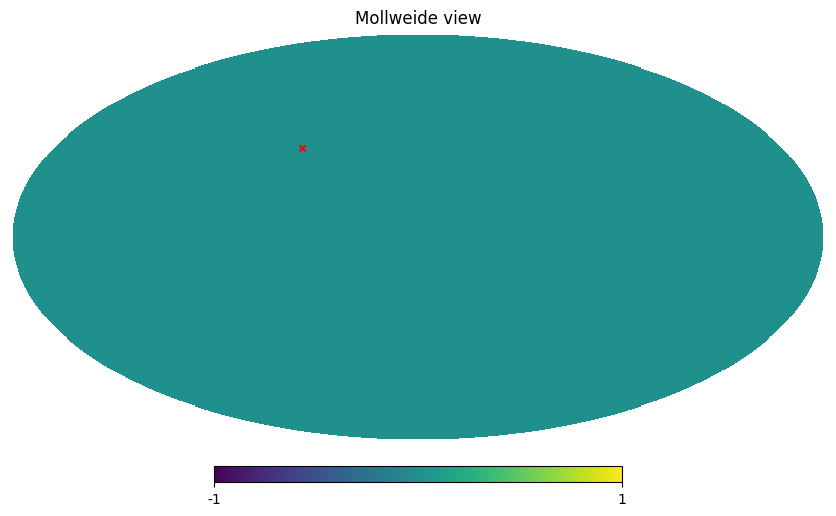

In [129]:
# set the resolution of the skymap
nside = 64

# define the theta-phi coordinate of the point you want to plot
theta = 0.5  # in radians
phi = 1.2  # in radians

# convert theta-phi coordinates to pixel index
pixel_index = hp.ang2pix(Nside3, theta1, phi1)

# create a map of zeros with nside resolution
skymap = np.zeros(hp.nside2npix(nside))

# set the pixel corresponding to the point to 1
#skymap[pixel_index] = 1

# plot the skymap
hp.mollview(skymap)

# plot the point on the skymap
hp.visufunc.projscatter(phi1, theta1, s=20, c='red', marker='x')

print(theta1, phi1)
# show the plot
plt.show()

In [44]:
#Plotting mean acceleration 